# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLVU/HW4/'

/content/drive/MyDrive/MLVU/HW4


# Import Modules

In [ ]:
import os
import sys
import cv2
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.manifold import TSNE
from tensorflow.keras.utils import Sequence

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

In [ ]:
"""
Make sure your runtime type is GPU!
"""
cpus = tf.config.list_physical_devices('CPU')
gpus = tf.config.list_physical_devices('GPU')
print('Num_CPUs:{}, List:{}'.format(len(cpus), cpus))
print('Num_GPUs:{}, List:{}'.format(len(gpus), gpus))

Num_CPUs:1, List:[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Utils

In [ ]:
def plot_dataset(images, labels, grid_width, grid_height, figure_width=5, figure_height=5, y_hats=None):
    """
    Plots image and labels.

    Do NOT modify this method.
    """
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = InputPipelineBuilder.LABELS[label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            ax[i][j].imshow(image[...,0], aspect='auto', cmap='gray')
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)
    plt.show()    

# MNIST

In [ ]:
class InputPipelineBuilder:
    """
    MNIST Input Pipeline
    """
    # pipeline configurations
    FRAME_SIZE = (28,28)      
    INPUT_SHAPE = [*FRAME_SIZE, 1]
    SUBSETS = ['train', 'valid']
    LABELS = np.arange(10)

    def __init__(self):
        """
        Do NOT modify this method.
        """        
        self.x = {}
        self.y = {}

    def __str__(self):
        """
        Print the input pipeline configuration and data subsets.
        
        Do NOT modify this method.
        """
        info = ''
        info += f'Labels: {InputPipelineBuilder.LABELS}\n'
        info += f'Dimension to use: {[*InputPipelineBuilder.INPUT_SHAPE]}\n'
        info += 'Dataset splitted: '
        if self.x:
            for subset in InputPipelineBuilder.SUBSETS:
                info += f'{subset}({len(self.x[subset])}) '
        return info
    
    def split_dataset(self,):
        """
        Load and split tfds MNIST dataset.

        Do NOT modify this method.
        """
        for subset in InputPipelineBuilder.SUBSETS:
            split = 'test' if subset=='valid' else subset
            self.x[subset], self.y[subset] = tfds.as_numpy(tfds.load('mnist', split=split, batch_size=-1, as_supervised=True))

    def get_dataset(self, subset, n_images_per_class=2, shuffle=False):
        """
        Do NOT modify this method.
        """
        assert subset in InputPipelineBuilder.SUBSETS, 'subset supported: {}'.format(InputPipelineBuilder.SUBSETS)
        loader = DataLoader(self.x[subset], self.y[subset], self.preprocess, shuffle=shuffle)
        return loader
            
    def preprocess(self, image):
        """
        Do NOT modify this method.
        """
        image = np.expand_dims(cv2.resize(image, InputPipelineBuilder.FRAME_SIZE, interpolation=cv2.INTER_AREA), axis=-1)
        image = image / 255.
        return image

class DataLoader(Sequence):
    """
    MNIST Data Loader
    """
    def __init__(self, x, y, preprocess, shuffle=False):
        """
        Do NOT modify this method.
        """
        self.x, self.y = x, y
        self.num_images = len(x)
        self.preprocess = preprocess
        self.shuffle = shuffle
        self.batch_size = 1
        self.on_epoch_end()
            
    def __len__(self):
        """
        Do NOT modify this method.
        """
        return math.floor(self.num_images / self.batch_size)
    
    def __getitem__(self, idx):
        """
        Do NOT modify this method.
        """
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        x_batch = np.array([self.preprocess(self.x[i]) for i in indices])
        y_batch = np.array([self.y[i] for i in indices])
        return x_batch, y_batch
    
    def on_epoch_end(self):
        """
        Do NOT modify this method.
        """
        self.indices = np.arange(self.num_images)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def batch(self, batch_size):
        """
        Do NOT modify this method.
        """
        self.batch_size = batch_size
        return self
    
    def load_image(self, image):
        """
        Do NOT modify this method.
        """
        image = cv2.imread(image)
        image = self.preprocess(image)
        return np.asarray(image)

In [ ]:
"""
Builds a MNIST input pipeline
"""
input_pipeline_builder = InputPipelineBuilder()
input_pipeline_builder.split_dataset()
print(input_pipeline_builder)

Labels: [0 1 2 3 4 5 6 7 8 9]
Dimension to use: [28, 28, 1]
Dataset splitted: train(60000) valid(10000) 


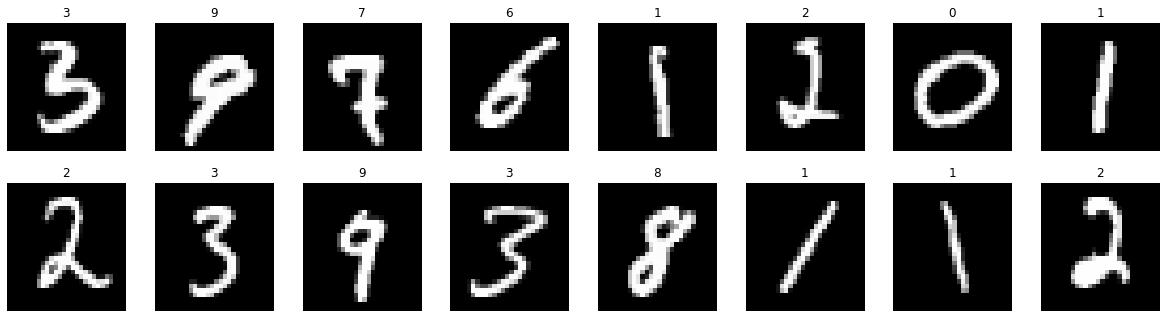

In [ ]:
train_loader = input_pipeline_builder.get_dataset('train', shuffle=True).batch(16)
x, y = train_loader[np.random.randint(0, len(train_loader))]
plot_dataset(x, y, 8, 2, figure_width=16, figure_height=4)

# MNISTNet

In [ ]:
class MNISTNet:
    def __init__(self, input_shape):
        """
        Do NOT modify this method.
        """
        inputs = tf.keras.Input(input_shape, dtype=tf.float32)
        x = Conv2D(64, [3,3], padding='same', activation=tf.nn.relu)(inputs)
        x = MaxPooling2D()(x)
        x = Conv2D(64, [3,3], padding='same', activation=tf.nn.relu)(x)
        x = MaxPooling2D()(x)
        x = Flatten()(x)
        x = Dropout(0.1)(x)
        outputs = Dense(64)(x)
        self.model = tf.keras.Model(inputs, outputs)
        
    def forward(self, inputs, l2_normalize=False):
        """
        Do NOT modify this method.
        """
        outputs = self.model(inputs)
        if l2_normalize:
            outputs = tf.math.l2_normalize(outputs, axis=-1)
        return outputs
    
    def backward(self, loss, tape):
        """
        Do NOT modify this method.
        """
        grads = tape.gradient(loss, self.model.trainable_variables)
        grads_dict = zip(grads, self.model.trainable_variables)
        return grads_dict
    
    def __str__(self):
        """
        Do NOT modify this method.
        """
        str_list = []
        self.model.summary(print_fn=lambda x: str_list.append(x))
        summary = '\n'.join(str_list)
        return summary

# Triplet Loss with Online Triplet Mining

In [ ]:
class TripletLoss:
    def __init__(self, alpha=1.0):
        """
        Do NOT Modify this method.

        Input
        - alpha: the margin for the triplet loss.
        """
        self.alpha = alpha 

    def get_triplet_mask(self, labels):
        """
        Returns a mask for valid triplets.

        Do NOT Modify this method.
        Input
        - labels
        Outputs
        - a mask matrix for the valid triplets.
        """
        indices_equal = tf.eye(labels.shape[0], dtype=tf.bool)
        indices_not_equal = tf.logical_not(indices_equal)
        i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
        i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
        j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

        distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)

        label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
        i_equal_j = tf.expand_dims(label_equal, 2)
        i_equal_k = tf.expand_dims(label_equal, 1)

        valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))
        mask = tf.logical_and(distinct_indices, valid_labels)
        return tf.cast(mask, tf.float32)

    def get_pairwise_distances(self, embeddings):
        """
        Computes the pairwise distance matrix of embeddings.

        Question (a)
        - You will need to care about efficiency like below ...
        - |a-b|^2 = |a|^2 - 2*<a,b> + |b|^2 where the diagonal of <a,b> contains the squared terms.
          Use tf.linglag.diag_part to extract the diagonal term.
        - To comptue a 2D pairwise distance matrix from a vector, use Tensor broadcasting.
          tf.expand_dims(|a|^2,0) and tf.expand_dims(|b|^2,1) will be useful.
        - Distance matrix might contain negative values due to computation error, so tf.maximum is used at the end.

        Inputs
        - embeddings: TF Tensor of size (the number of embeddings, embedding dimension)
        Outputs
        - distances: tf Tensor containing pairwise distances of size (the number of embeddings, the number of embeddings)
        """
        ee = embeddings@tf.transpose(embeddings)
        vector_norms = tf.linalg.diag_part(ee)
        distances = -2*ee + tf.expand_dims(vector_norms,0) + tf.expand_dims(vector_norms,1)
        return tf.maximum(distances, 0.0)
    
    def __call__(self, labels, embeddings):
        """
        Compute the loss after performing online triplet mining of every valid triplets among the given embeddings.
        The loss is divided by the number of the valid triplets at the end.
        Invalid triplets are defined as the ones where label(anchor)!=label(positive) or label(negative)==label(positive) or the embedding itself.
        Please refer to the TripletSemiHardLoss implementation of TF Addon library if you are instrested in other mining methods.

        Question (b)
          - Complete the lines within the block to compute a 3-dimensional triplet loss matrix.
          - the (i,j,k)th entry contains the triplet loss of the i-th embedding as anchor, the j-th as positive, the k-th as negative.
          - triplet loss is defined as (a,p) distance - (a,n) distance + margin.
          - use Tensor Broadcasting.
          - use self.alpha for the margin.
        """        
        pairwise_dist = self.get_pairwise_distances(embeddings)

        ### YOUR CODE STARTS HERE
        '''
        For Loop Implementation
        for i in range(3):
          for j in range(3):
            for k in range(3):
              TL1[i,j,k] = dist[i,j]-dist[i,k]
        This is equivalent with below broadcasted solution: https://omoindrot.github.io/triplet-loss
        '''
        anchor_positive_dist = tf.expand_dims(pairwise_dist,2)
        anchor_negative_dist = tf.expand_dims(pairwise_dist,1)
        triplet_loss = anchor_positive_dist - anchor_negative_dist + self.alpha 
        ### YOUR CODE ENDS HERE

        # get a mask to filter invalid triplets
        mask = self.get_triplet_mask(labels)
        triplet_loss = tf.maximum(tf.multiply(mask, triplet_loss), 0.0)
        
        # count the number of the triplets with loss > 0
        valid_triplets = tf.cast(tf.greater(triplet_loss, 0.0), tf.float32)
        num_positive_triplets = tf.reduce_sum(valid_triplets)
        num_valid_triplets = tf.reduce_sum(mask)
        fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

        triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)
        return triplet_loss

# Traininig

In [ ]:
### 
# Question (c)
# Train the MNISTNet until its training loss becomes less than 0.2.
# You can try or add other training options such as SGD or callbacks to schedule learning rates if you want.
### 

In [ ]:
# Modify as you want
batch_size = 256
num_epochs = 20
alpha = 1.0
learning_rate = 0.001
load_weights = False
print_summary = True

ckpt_path = './ckpts'

In [ ]:
train_loader = input_pipeline_builder.get_dataset('train', shuffle=True).batch(batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
metric = tf.keras.metrics.SparseCategoricalAccuracy()
loss_fn = TripletLoss(alpha=alpha)

tf.keras.backend.clear_session()        
mninst_net = MNISTNet(InputPipelineBuilder.INPUT_SHAPE)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=mninst_net.model)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=3)
if load_weights and ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")
if print_summary:
    print(mninst_net)

Initializing from scratch.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None

In [ ]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
for epoch in range(num_epochs):    
    for step, (imgs, labels) in enumerate(tqdm(train_loader)):
        with tf.GradientTape() as tape:
            embeddings = mninst_net.forward(imgs, l2_normalize=True)
            loss  = loss_fn(labels, embeddings)
        grads_dict = mninst_net.backward(loss, tape)
        optimizer.apply_gradients(grads_dict)
        train_loss(loss)
    print (f'Epoch: {epoch+1} - loss: {train_loss.result()}')
    train_loss.reset_states()
    ckpt.step.assign_add(1)
    save_path = ckpt_manager.save()

100%|██████████| 234/234 [00:40<00:00,  5.78it/s]


Epoch: 1 - loss: 0.41603076457977295


100%|██████████| 234/234 [00:13<00:00, 17.79it/s]


Epoch: 2 - loss: 0.34555408358573914


100%|██████████| 234/234 [00:13<00:00, 17.91it/s]


Epoch: 3 - loss: 0.3204561769962311


100%|██████████| 234/234 [00:13<00:00, 17.84it/s]


Epoch: 4 - loss: 0.29869556427001953


100%|██████████| 234/234 [00:13<00:00, 17.87it/s]


Epoch: 5 - loss: 0.28176459670066833


100%|██████████| 234/234 [00:13<00:00, 17.89it/s]


Epoch: 6 - loss: 0.266021192073822


100%|██████████| 234/234 [00:13<00:00, 17.96it/s]


Epoch: 7 - loss: 0.25559020042419434


100%|██████████| 234/234 [00:13<00:00, 17.86it/s]


Epoch: 8 - loss: 0.24187211692333221


100%|██████████| 234/234 [00:12<00:00, 18.02it/s]


Epoch: 9 - loss: 0.22684672474861145


100%|██████████| 234/234 [00:13<00:00, 17.79it/s]


Epoch: 10 - loss: 0.21485796570777893


100%|██████████| 234/234 [00:13<00:00, 18.00it/s]


Epoch: 11 - loss: 0.20558352768421173


100%|██████████| 234/234 [00:12<00:00, 18.07it/s]


Epoch: 12 - loss: 0.2009197473526001


100%|██████████| 234/234 [00:12<00:00, 18.01it/s]


Epoch: 13 - loss: 0.1898738592863083


100%|██████████| 234/234 [00:12<00:00, 18.10it/s]


Epoch: 14 - loss: 0.18977558612823486


100%|██████████| 234/234 [00:13<00:00, 17.89it/s]


Epoch: 15 - loss: 0.18320044875144958


100%|██████████| 234/234 [00:12<00:00, 18.03it/s]


Epoch: 16 - loss: 0.17616619169712067


100%|██████████| 234/234 [00:13<00:00, 17.98it/s]


Epoch: 17 - loss: 0.16678661108016968


100%|██████████| 234/234 [00:13<00:00, 17.85it/s]


Epoch: 18 - loss: 0.16132597625255585


100%|██████████| 234/234 [00:13<00:00, 17.87it/s]


Epoch: 19 - loss: 0.1605457365512848


100%|██████████| 234/234 [00:13<00:00, 17.88it/s]


Epoch: 20 - loss: 0.16016508638858795


# t-SNE

In [ ]:
### 
# Question (d)
# Visualize the embeddings predicted.
# Clusters should be observed in the plot.
### 

In [ ]:
num_points_to_plot = 1024
mninst_net_not_trained = MNISTNet(InputPipelineBuilder.INPUT_SHAPE)

In [ ]:
valid_loader = input_pipeline_builder.get_dataset('valid', shuffle=False).batch(num_points_to_plot)
imgs_valid, labels_valid = valid_loader[np.random.randint(0, len(valid_loader))]
embeddings_before = mninst_net_not_trained.forward(imgs_valid)
embeddings_after = mninst_net.forward(imgs_valid)

In [ ]:
tsne_before = TSNE(3).fit_transform(embeddings_before)
tsne_after = TSNE(3).fit_transform(embeddings_after)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


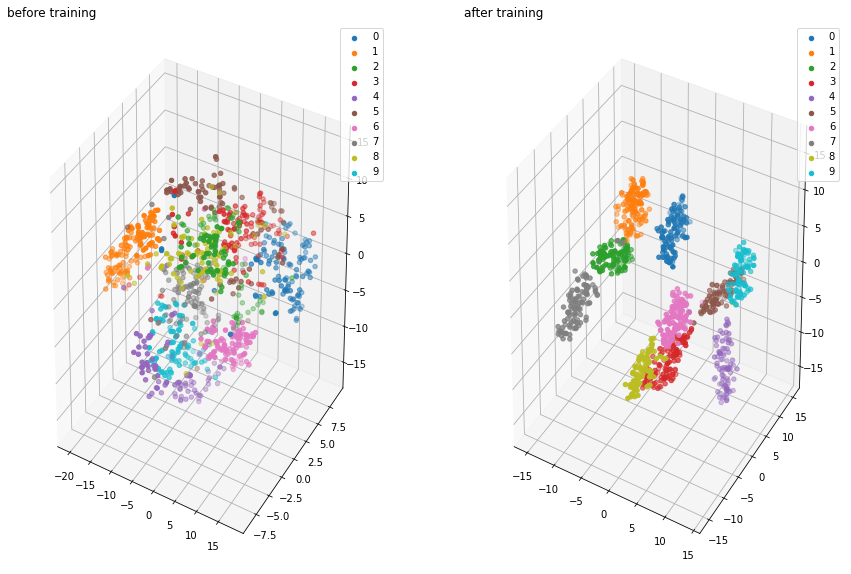

In [ ]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
for label in InputPipelineBuilder.LABELS:
    idxs = labels_valid==label
    ax.scatter3D(tsne_before[idxs,0], tsne_before[idxs,1], tsne_before[idxs,2], label=label)
    ax.set_title('before training', loc='left')
    ax.legend()
    
ax = fig.add_subplot(1, 2, 2, projection='3d')
for label in InputPipelineBuilder.LABELS:
    idxs = labels_valid==label
    ax.scatter3D(tsne_after[idxs,0], tsne_after[idxs,1], tsne_after[idxs,2], label=label)
    ax.set_title('after training', loc='left')
    ax.legend()

plt.show()

# MNIST Image Classification

In [ ]:
### 
# Question (e)
# Use the predicted embeddings to perform image classification task and compare the result with that of random embeddings.
# Only one linear layer head is attached to the frozen MNISTNet.
# Validation accuarcy should be 70% or above.
### 

### Embedding randomly initialized + Classification Head

In [ ]:
base = mninst_net_not_trained.model
base.trainable = False

inputs = tf.keras.Input(InputPipelineBuilder.INPUT_SHAPE, dtype=tf.float32)
x = base(inputs)
outputs = Dense(len(InputPipelineBuilder.LABELS))(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
model.summary()

history = model.fit(train_loader, validation_data=valid_loader, epochs=1, workers=4)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 64)                238336    
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 238,986
Trainable params: 650
Non-trainable params: 238,336
_________________________________________________________________
234/234 [==============================] - 9s 35ms/step - loss: 3.9267 - accuracy: 0.1264 - val_loss: 3.3123 - val_accuracy: 0.2095


### Embedding trained with Triplet Loss + Classification Head

In [ ]:
base = mninst_net.model
base.trainable = False

inputs = tf.keras.Input(InputPipelineBuilder.INPUT_SHAPE, dtype=tf.float32)
x = base(inputs)
outputs = Dense(len(InputPipelineBuilder.LABELS))(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
model.summary()

history = model.fit(train_loader, validation_data=valid_loader, epochs=1, workers=4)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 64)                238336    
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 238,986
Trainable params: 650
Non-trainable params: 238,336
_________________________________________________________________
234/234 [==============================] - 9s 35ms/step - loss: 1.7299 - accuracy: 0.6978 - val_loss: 0.4955 - val_accuracy: 0.9182
